# 1 - Analyse exploratoire des données

## 1.1 - Importation des bibliothèques

In [1]:
from typing import dataclass_transform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import fonctions as f
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score

## 1.2 - Chargement du dataset

In [2]:
dataset = pd.read_csv('data/2016_Building_Energy_Benchmarking.csv')

## 1.3 - Analyse globale du dataset

Analyse du fichier dataset :
Forme du fichier : (3376, 46)
--------------------------------------------------
Il y a 0 doublons
--------------------------------------------------
Données manquantes par colonne :
OSEBuildingID                         0
DataYear                              0
BuildingType                          0
PrimaryPropertyType                   0
PropertyName                          0
Address                               0
City                                  0
State                                 0
ZipCode                              16
TaxParcelIdentificationNumber         0
CouncilDistrictCode                   0
Neighborhood                          0
Latitude                              0
Longitude                             0
YearBuilt                             0
NumberofBuildings                     8
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
PropertyGFABuilding(s)      

<Axes: >

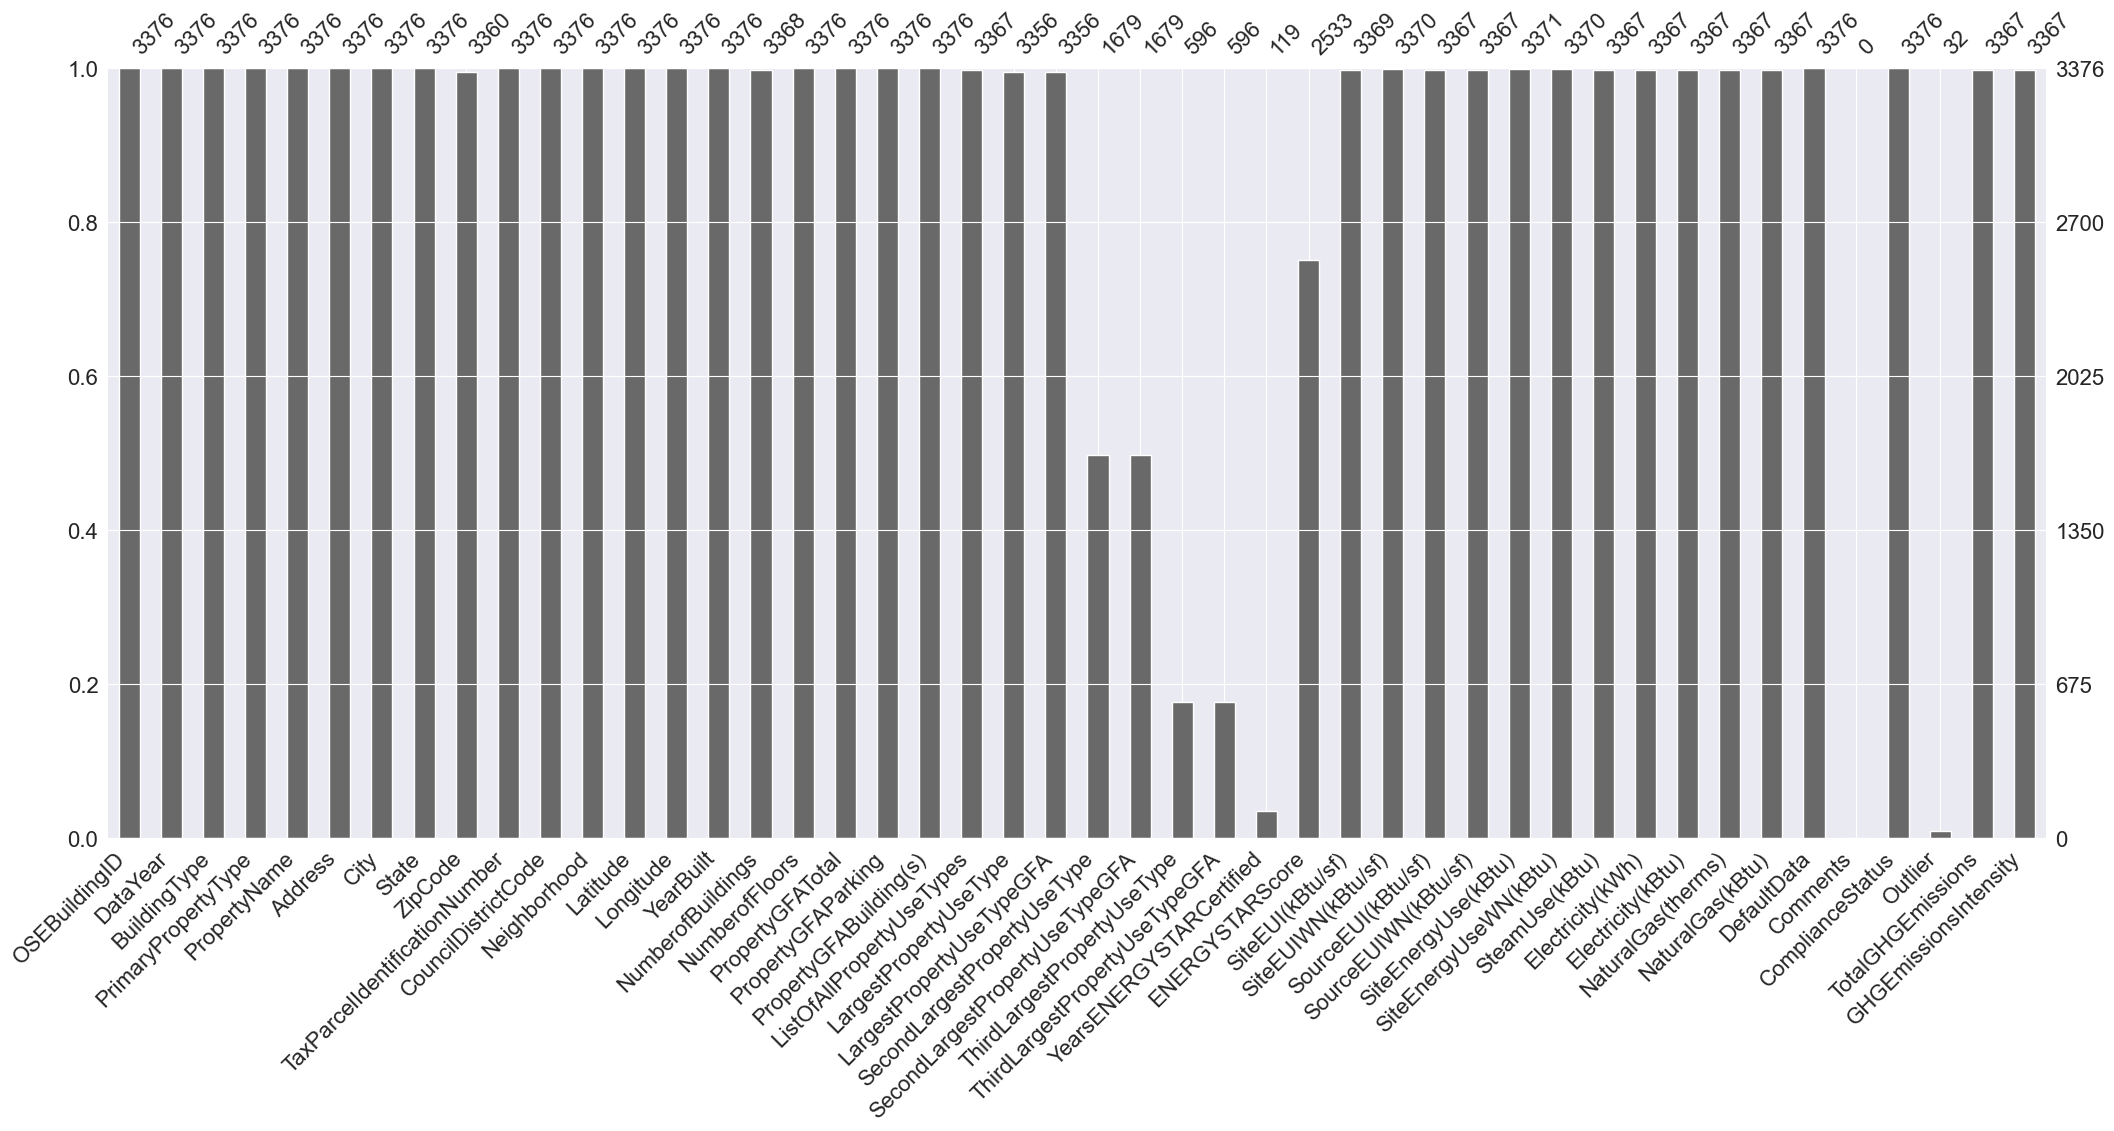

In [3]:
f.analyse(dataset, 'dataset')
msno.bar(dataset)

## 1.4 - Aperçu initial

In [4]:
dataset.head(100)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.529300,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.816410,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.000000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.130860,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5368607.0,88039.984380,8803998.0,False,NaN,Compliant,NaN,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,140,2016,SPS-District K-12,K-12 School,B.F. Day Elementary,3921 Linden Ave. N.,Seattle,WA,98103.0,1931301145,...,6.167308e+05,2104286.0,0.000000,0.0,False,NaN,Missing Data,NaN,14.67,0.22
96,144,2016,NonResidential,Hotel,Alexis Hotel,1007 First Ave.,Seattle,WA,98104.0,1974600035,...,1.290419e+06,4402910.0,21030.839840,2103084.0,False,NaN,Compliant,NaN,142.39,0.75
97,145,2016,Nonresidential COS,Other,Benaroya Hall,200 University Street,Seattle,WA,98111.0,1974700025,...,2.873101e+06,9803021.0,5273.430176,527343.0,False,NaN,Compliant,NaN,429.12,1.51
98,147,2016,NonResidential,Hospital,Swedish Ballard,5300 Tallman Ave NW,Seattle,WA,98107.0,2767703875,...,1.032743e+07,35237205.0,328535.125000,32853512.0,False,NaN,Compliant,NaN,1990.50,6.98


## 1.5 - Filtrage des bâtiments non résidentiels et conformes

In [5]:
dataset = dataset[dataset["BuildingType"] == "NonResidential"]
dataset = dataset[dataset["Outlier"] != "Yes"]
dataset = dataset[dataset["ComplianceStatus"] == "Compliant"]
dataset = dataset[dataset["TotalGHGEmissions"] >= 0]

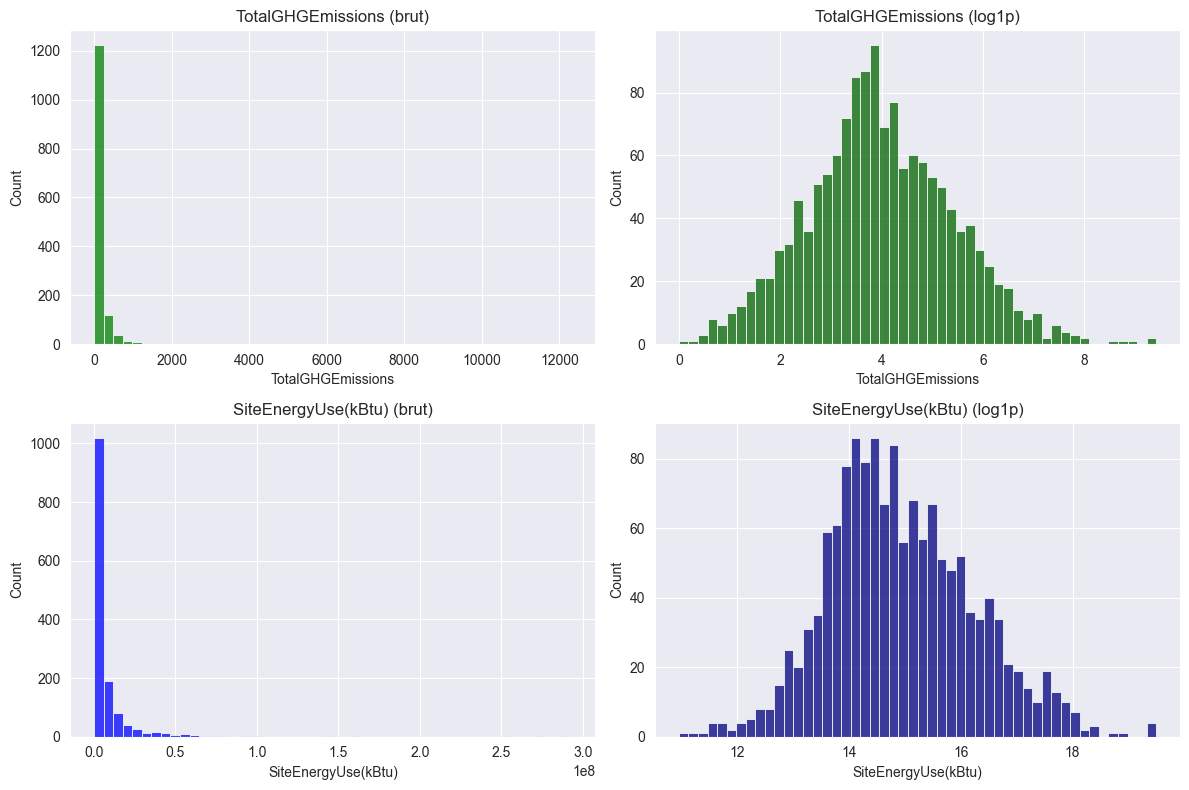

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

sns.histplot(dataset["TotalGHGEmissions"], bins=50, ax=axs[0, 0], color="green")
axs[0, 0].set_title("TotalGHGEmissions (brut)")

sns.histplot(np.log1p(dataset["TotalGHGEmissions"]), bins=50, ax=axs[0, 1], color="darkgreen")
axs[0, 1].set_title("TotalGHGEmissions (log1p)")

sns.histplot(dataset["SiteEnergyUse(kBtu)"], bins=50, ax=axs[1, 0], color="blue")
axs[1, 0].set_title("SiteEnergyUse(kBtu) (brut)")

sns.histplot(np.log1p(dataset["SiteEnergyUse(kBtu)"]), bins=50, ax=axs[1, 1], color="navy")
axs[1, 1].set_title("SiteEnergyUse(kBtu) (log1p)")

plt.tight_layout()
plt.show()

- Seuls les bâtiments **non résidentiels, conformes** et **sans valeurs aberrantes déclarées** sont conservés.
- Cela garantit que les données utilisées sont représentatives, cohérentes et exploitables.

## 1.6 - Visualisation des distributions des cibles

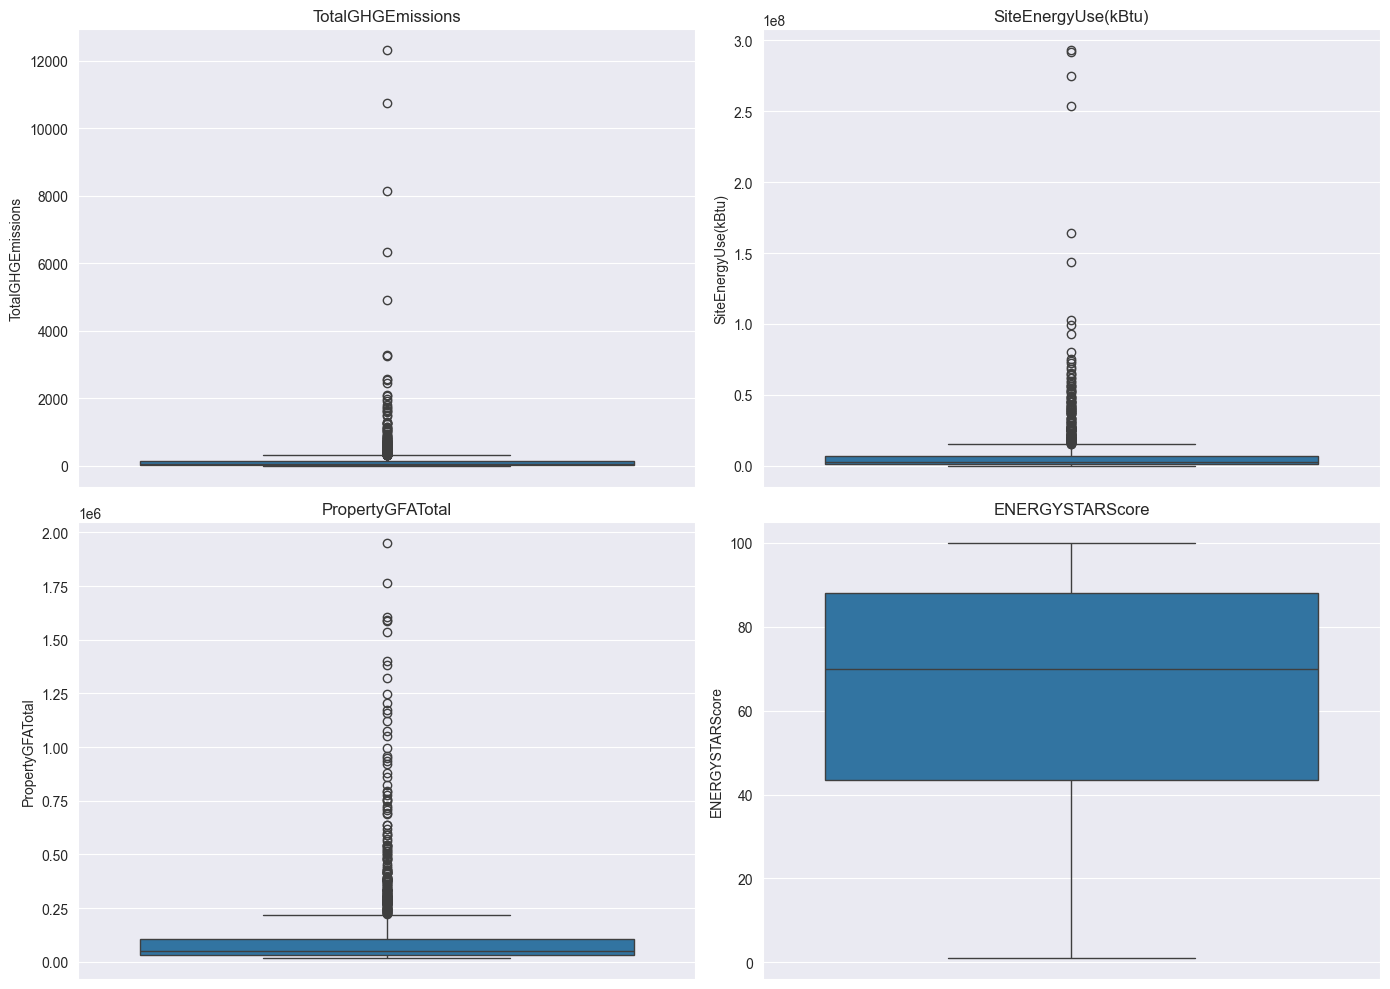

In [7]:
# Visualisation des distributions avec boxplots pour identifier les outliers
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

sns.boxplot(y=dataset["TotalGHGEmissions"], ax=axs[0, 0])
axs[0, 0].set_title("TotalGHGEmissions")

sns.boxplot(y=dataset["SiteEnergyUse(kBtu)"], ax=axs[0, 1])
axs[0, 1].set_title("SiteEnergyUse(kBtu)")

sns.boxplot(y=dataset["PropertyGFATotal"], ax=axs[1, 0])
axs[1, 0].set_title("PropertyGFATotal")

sns.boxplot(y=dataset["ENERGYSTARScore"], ax=axs[1, 1])
axs[1, 1].set_title("ENERGYSTARScore")

plt.tight_layout()
plt.show()


=== DIAGNOSTIC DE LA VARIABLE CIBLE ===
Statistiques descriptives pour TotalGHGEmissions:
count     1431.000000
mean       168.864612
std        591.225062
min          0.000000
1%           1.306000
5%           4.100000
10%          7.560000
25%         19.790000
50%         48.350000
75%        134.630000
90%        341.230000
95%        585.735000
99%       1770.916000
max      12307.160000
Name: TotalGHGEmissions, dtype: float64


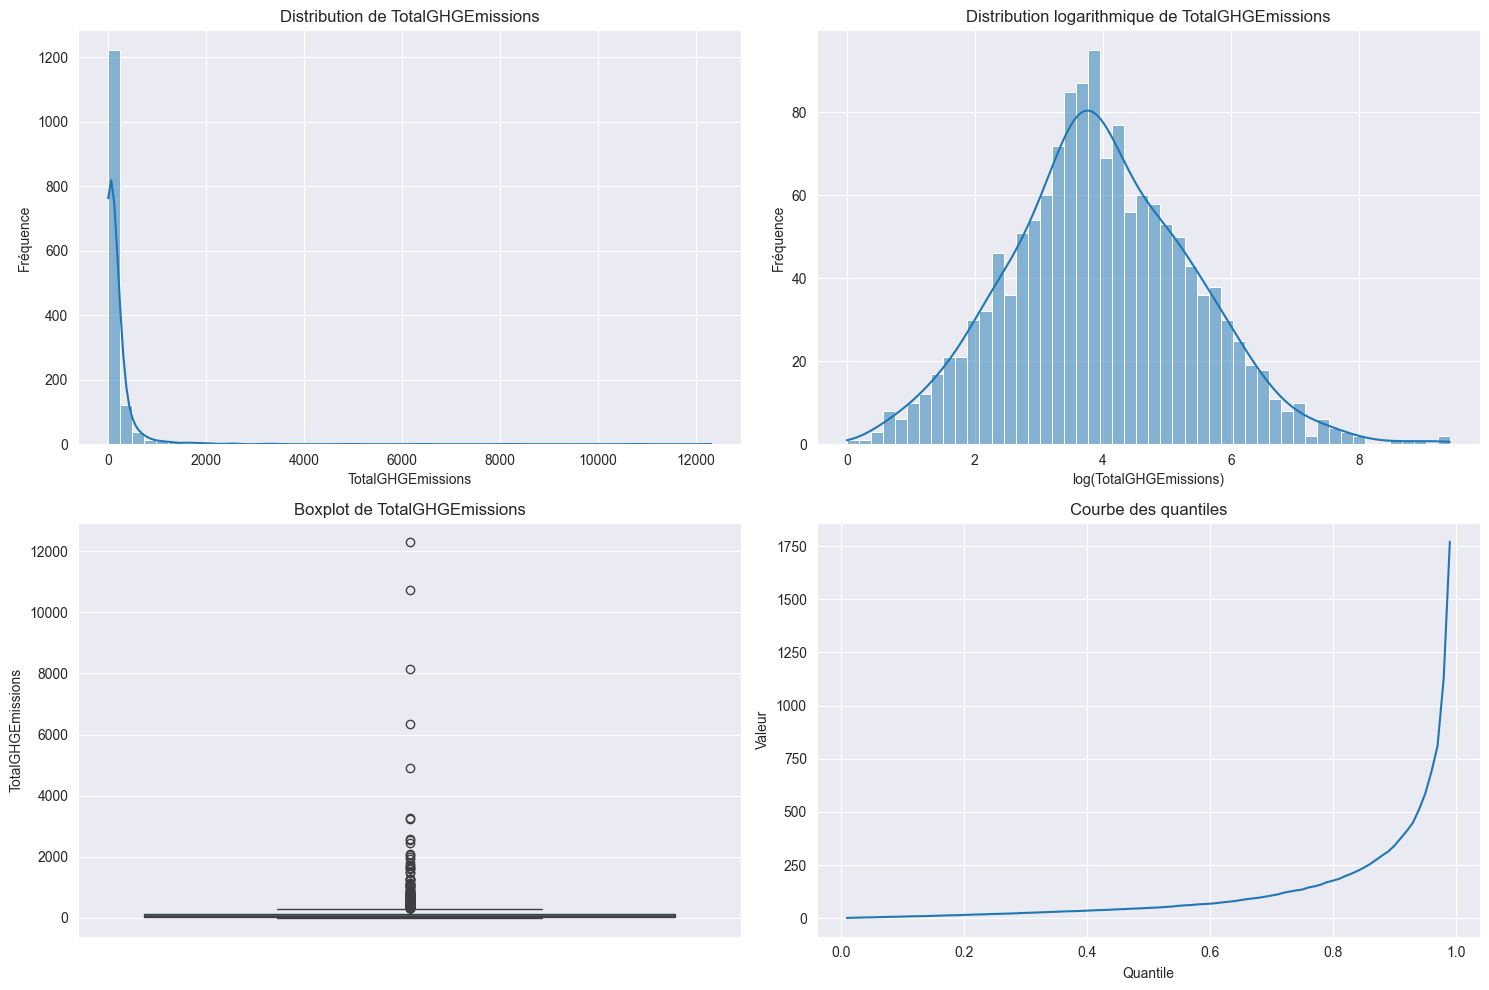


Identification des outliers extrêmes:
Nombre d'outliers extrêmes (>99%): 15
Valeur maximale: 12307.16
Seuil 99%: 1770.916000000003
Ratio max/seuil: 6.95x

Caractéristiques des outliers extrêmes:
Surface moyenne des bâtiments normaux: 107587.90
Surface moyenne des outliers: 653179.60
Ratio: 6.07x

Filtrage de 5 valeurs extrêmement aberrantes (>100x la médiane)


In [8]:
# Diagnostic des problèmes de distribution de la cible
def target_diagnostic(df, target_col='TotalGHGEmissions'):
    """
    Diagnostique approfondi de la distribution de la variable cible
    pour identifier les problèmes fondamentaux
    """
    print("\n=== DIAGNOSTIC DE LA VARIABLE CIBLE ===")
    print(f"Statistiques descriptives pour {target_col}:")
    stats = df[target_col].describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
    print(stats)

    # Visualisation de la distribution
    plt.figure(figsize=(15, 10))

    # Histogramme de base
    plt.subplot(2, 2, 1)
    sns.histplot(df[target_col], bins=50, kde=True)
    plt.title(f"Distribution de {target_col}")
    plt.xlabel(target_col)
    plt.ylabel("Fréquence")

    # Distribution logarithmique
    plt.subplot(2, 2, 2)
    sns.histplot(np.log1p(df[target_col]), bins=50, kde=True)
    plt.title(f"Distribution logarithmique de {target_col}")
    plt.xlabel(f"log({target_col})")
    plt.ylabel("Fréquence")

    # Boxplot pour les outliers
    plt.subplot(2, 2, 3)
    sns.boxplot(y=df[target_col])
    plt.title(f"Boxplot de {target_col}")
    plt.ylabel(target_col)

    # Quantile plot
    plt.subplot(2, 2, 4)
    q = np.arange(0.01, 1, 0.01)
    quantiles = np.quantile(df[target_col], q)
    plt.plot(q, quantiles)
    plt.title("Courbe des quantiles")
    plt.xlabel("Quantile")
    plt.ylabel("Valeur")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Identification des outliers extrêmes
    print("\nIdentification des outliers extrêmes:")
    upper_threshold = df[target_col].quantile(0.99)
    extreme_outliers = df[df[target_col] > upper_threshold]
    print(f"Nombre d'outliers extrêmes (>99%): {len(extreme_outliers)}")
    print(f"Valeur maximale: {df[target_col].max()}")
    print(f"Seuil 99%: {upper_threshold}")
    print(f"Ratio max/seuil: {df[target_col].max() / upper_threshold:.2f}x")

    if len(extreme_outliers) > 0:
        print("\nCaractéristiques des outliers extrêmes:")
        if 'PropertyGFATotal' in df.columns:
            print(
                f"Surface moyenne des bâtiments normaux: {df[df[target_col] <= upper_threshold]['PropertyGFATotal'].mean():.2f}")
            print(f"Surface moyenne des outliers: {extreme_outliers['PropertyGFATotal'].mean():.2f}")
            print(
                f"Ratio: {extreme_outliers['PropertyGFATotal'].mean() / df[df[target_col] <= upper_threshold]['PropertyGFATotal'].mean():.2f}x")

    return extreme_outliers


# Exécuter le diagnostic
extreme_outliers = target_diagnostic(dataset)

# Nettoyage ciblé si nécessaire
if len(extreme_outliers) > 0:
    # Filtrer les outliers vraiment extrêmes (>100x la médiane)
    median_value = dataset['TotalGHGEmissions'].median()
    extreme_ratio = 100  # ajuster selon les résultats du diagnostic
    very_extreme = dataset[dataset['TotalGHGEmissions'] > median_value * extreme_ratio]

    if len(very_extreme) > 0:
        print(f"\nFiltrage de {len(very_extreme)} valeurs extrêmement aberrantes (>{extreme_ratio}x la médiane)")
        dataset_filtered_clean = dataset[dataset['TotalGHGEmissions'] <= median_value * extreme_ratio]
    else:
        print("Pas de valeurs extrêmement aberrantes détectées.")
else:
    print("Pas d'outliers extrêmes détectés. Le problème vient probablement de la distribution globale.")

- Les distributions brutes de `TotalGHGEmissions` et `SiteEnergyUse(kBtu)` sont **fortement asymétriques**, avec une longue traîne vers les hautes valeurs.
- Une transformation logarithmique (`log1p`) permet d'obtenir une répartition plus symétrique, ce qui facilitera la modélisation.

## 1.7 - Identification des valeurs manquantes

In [9]:
dataset.isnull().sum().sort_values(ascending=False)

Outlier                            1431
Comments                           1431
YearsENERGYSTARCertified           1341
ThirdLargestPropertyUseType        1121
ThirdLargestPropertyUseTypeGFA     1121
SecondLargestPropertyUseType        648
SecondLargestPropertyUseTypeGFA     648
ENERGYSTARScore                     456
LargestPropertyUseTypeGFA             4
LargestPropertyUseType                4
SiteEUIWN(kBtu/sf)                    1
SiteEnergyUseWN(kBtu)                 1
OSEBuildingID                         0
DataYear                              0
Longitude                             0
Latitude                              0
Neighborhood                          0
CouncilDistrictCode                   0
TaxParcelIdentificationNumber         0
ZipCode                               0
State                                 0
City                                  0
Address                               0
PropertyName                          0
PrimaryPropertyType                   0


## Création des colonnes du Mix Énergétique

In [10]:
dataset['TotalEnergy_kBtu'] = dataset['SteamUse(kBtu)'] + dataset['Electricity(kBtu)'] + dataset['NaturalGas(kBtu)']

dataset['Proportion_Steam'] = dataset['SteamUse(kBtu)'] / dataset['TotalEnergy_kBtu']
dataset['Proportion_Electricity'] = dataset['Electricity(kBtu)'] / dataset['TotalEnergy_kBtu']
dataset['Proportion_NaturalGas'] = dataset['NaturalGas(kBtu)'] / dataset['TotalEnergy_kBtu']

## 1.8 - Sélection des colonnes pertinentes

In [11]:
structure_cols = [
    "YearBuilt", "NumberofFloors", "NumberofBuildings",
    "PropertyGFATotal", "PropertyGFABuilding(s)", "PropertyGFAParking",
    "LargestPropertyUseType", "LargestPropertyUseTypeGFA",
    "SecondLargestPropertyUseType", "SecondLargestPropertyUseTypeGFA",
    "ThirdLargestPropertyUseType", "ThirdLargestPropertyUseTypeGFA",
    'Proportion_Steam','Proportion_Electricity','Proportion_NaturalGas'
]
location_cols = ["Latitude", "Longitude", "Neighborhood", "ZipCode"]
energy_score_cols = ["ENERGYSTARScore", "YearsENERGYSTARCertified"]
target_cols = ["TotalGHGEmissions", "SiteEnergyUse(kBtu)"]
all_selected_cols = structure_cols + location_cols + energy_score_cols + target_cols
retained_cols = [col for col in all_selected_cols if col in dataset.columns]

## 1.9 - Nettoyage + Feature engineering

In [12]:
dataset_model = dataset[retained_cols].copy()
dataset_model["BuildingAge"] = 2025 - dataset_model["YearBuilt"]
dataset_model["has_energy_star"] = dataset_model["ENERGYSTARScore"].notnull().astype(int)
dataset_model["SecondLargestPropertyUseType"].fillna("None", inplace=True)
dataset_model["SecondLargestPropertyUseTypeGFA"].fillna(0, inplace=True)
dataset_model["ThirdLargestPropertyUseType"].fillna("None", inplace=True)
dataset_model["ThirdLargestPropertyUseTypeGFA"].fillna(0, inplace=True)
dataset_model["ENERGYSTARScore"].fillna(-1, inplace=True)
dataset_model["YearsENERGYSTARCertified"].fillna("None", inplace=True)
dataset_model["LargestPropertyUseType"].fillna("None", inplace=True)
dataset_model["LargestPropertyUseTypeGFA"].fillna(0, inplace=True)

C:\Users\Thomas\AppData\Local\Temp\ipykernel_13152\3110259867.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset_model["SecondLargestPropertyUseType"].fillna("None", inplace=True)
C:\Users\Thomas\AppData\Local\Temp\ipykernel_13152\3110259867.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

In [13]:
# Suppression des incohérences connues
dataset_model = dataset_model[dataset_model["NumberofFloors"] > 0]
dataset_model = dataset_model[dataset_model["LargestPropertyUseTypeGFA"].notna()]

In [14]:
missing = dataset_model.isna().sum()
print(missing[missing > 0])

Proportion_Steam          1
Proportion_Electricity    1
Proportion_NaturalGas     1
dtype: int64


In [15]:
dataset_model[["Proportion_Steam", "Proportion_Electricity", "Proportion_NaturalGas"]] = (
    dataset_model[["Proportion_Steam", "Proportion_Electricity", "Proportion_NaturalGas"]].fillna(0)
)

## 1.10 - Corrélations linéaires (Pearson)

In [16]:
numeric_cols = dataset_model.select_dtypes(include=["int64", "float64"]).columns
corr_matrix = dataset_model[numeric_cols].corr()
corr_targets = corr_matrix[["TotalGHGEmissions", "SiteEnergyUse(kBtu)"]].drop(
    ["TotalGHGEmissions", "SiteEnergyUse(kBtu)"])
corr_targets.abs().sort_values(by="SiteEnergyUse(kBtu)", ascending=False)

,TotalGHGEmissions,SiteEnergyUse(kBtu)
LargestPropertyUseTypeGFA,0.572987,0.701598
PropertyGFABuilding(s),0.513335,0.670847
PropertyGFATotal,0.467022,0.642881
SecondLargestPropertyUseTypeGFA,0.370789,0.533744
NumberofBuildings,0.543774,0.451781
NumberofFloors,0.193413,0.389205
PropertyGFAParking,0.089624,0.253783
ThirdLargestPropertyUseTypeGFA,0.079033,0.220800
Proportion_Steam,0.284459,0.190434
BuildingAge,0.079421,0.153915


- Les variables les plus corrélées avec les cibles sont liées à la **surface des bâtiments** (ex : `LargestPropertyUseTypeGFA`, `PropertyGFATotal`).
- Ces variables structurelles sont donc **fortement prédictives** de la consommation d’énergie et des émissions de CO₂.

## 1.11 - Visualisation des corrélations fortes (scatterplots)

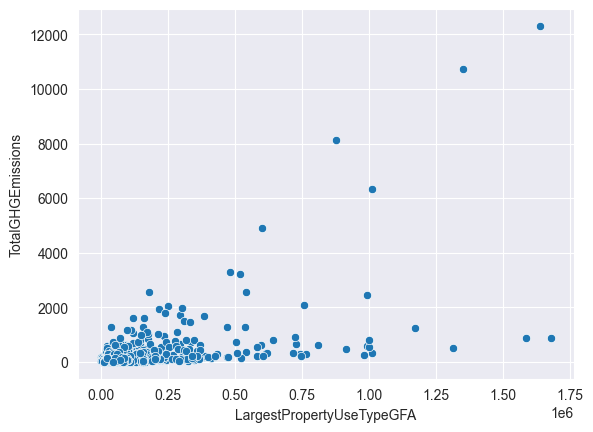

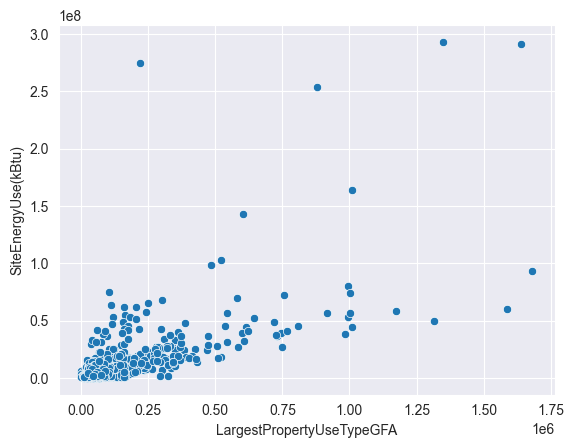

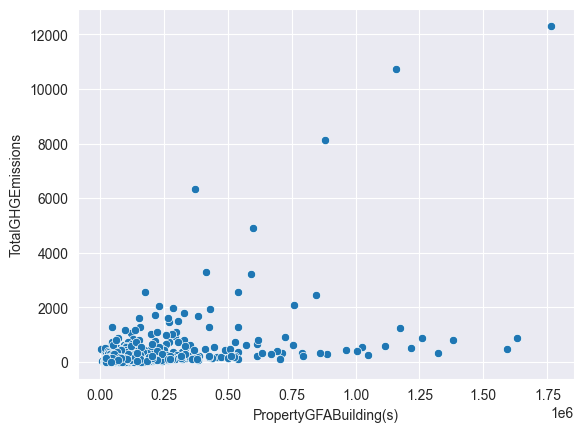

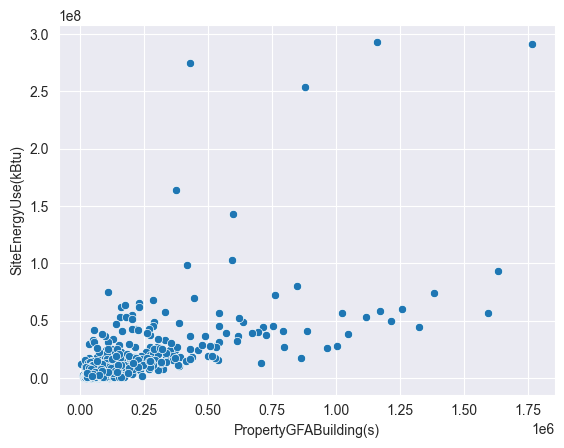

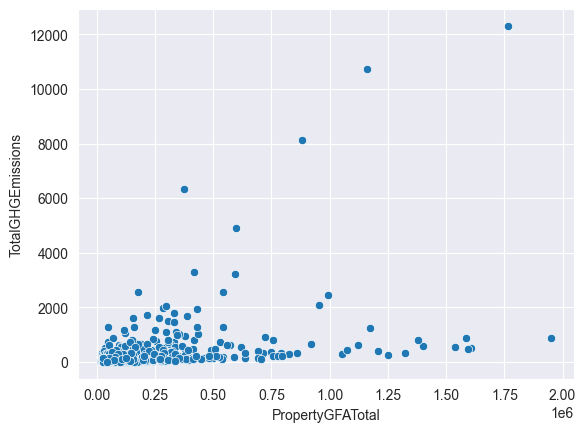

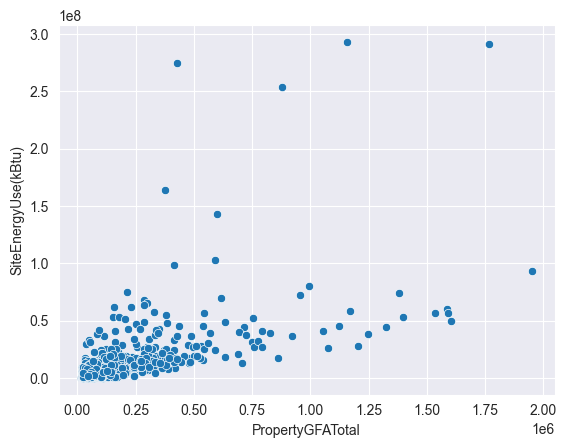

In [17]:
top_features = ["LargestPropertyUseTypeGFA", "PropertyGFABuilding(s)", "PropertyGFATotal"]
for feature in top_features:
    sns.scatterplot(x=feature, y="TotalGHGEmissions", data=dataset_model)
    plt.show()
    sns.scatterplot(x=feature, y="SiteEnergyUse(kBtu)", data=dataset_model)
    plt.show()

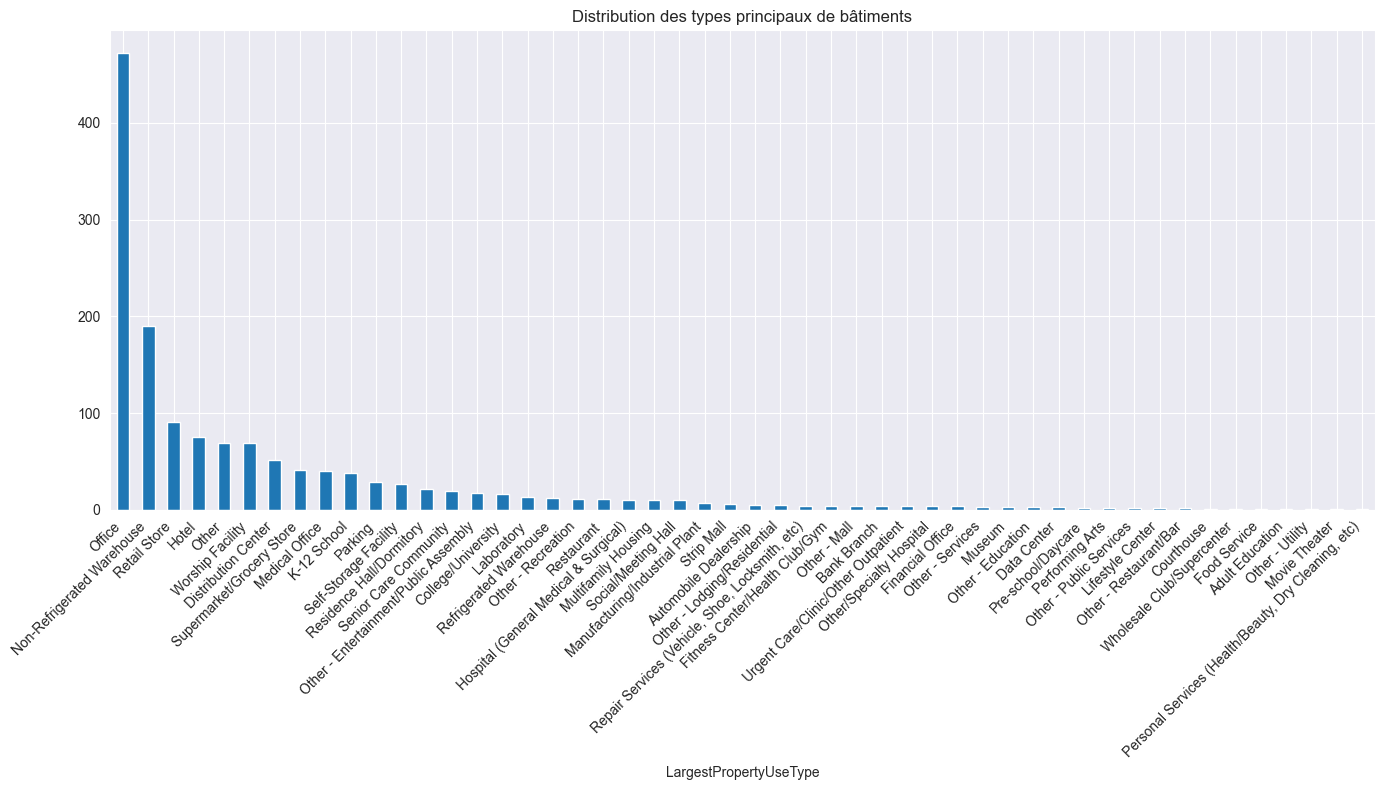

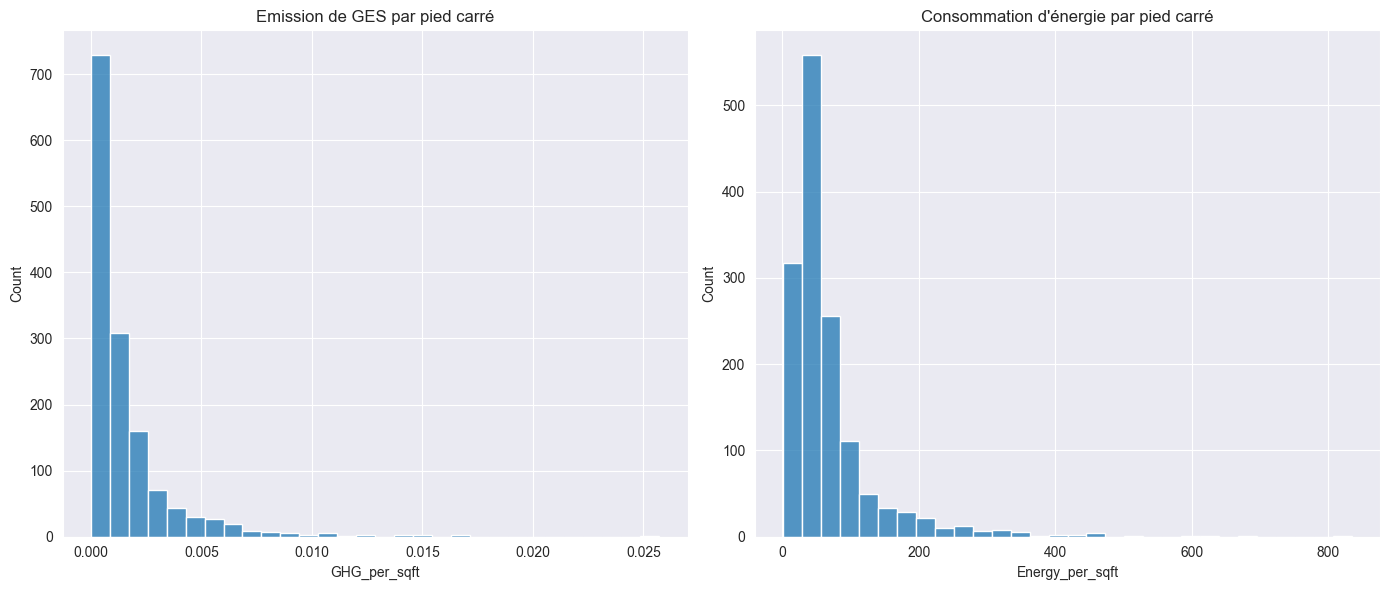

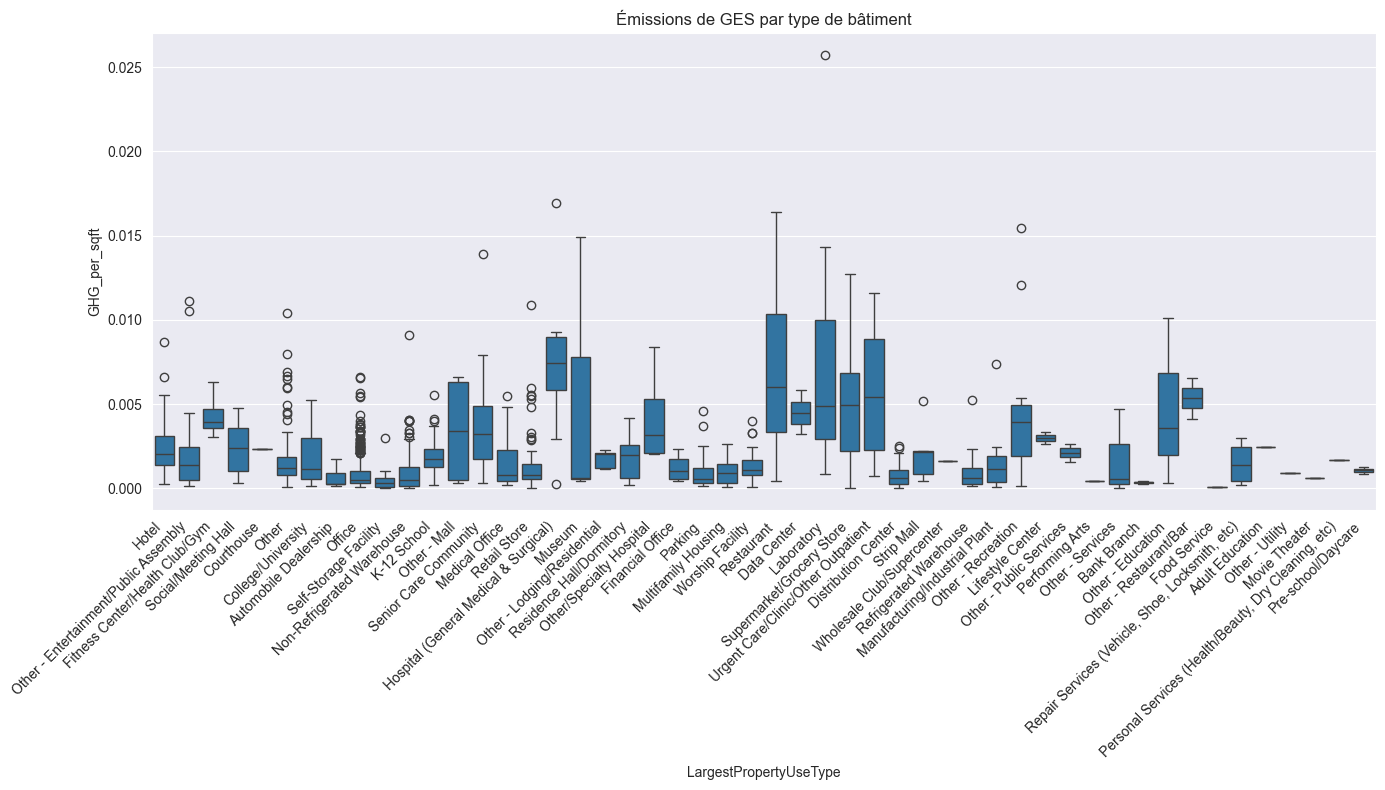

In [18]:
# Analyse des types d'utilisation des bâtiments
plt.figure(figsize=(14, 8))
dataset['LargestPropertyUseType'].value_counts().plot(kind='bar')
plt.title('Distribution des types principaux de bâtiments')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Création et analyse de features dérivées relatives
dataset['GHG_per_sqft'] = dataset['TotalGHGEmissions'] / dataset['PropertyGFATotal']
dataset['Energy_per_sqft'] = dataset['SiteEnergyUse(kBtu)'] / dataset['PropertyGFATotal']

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(dataset['GHG_per_sqft'], bins=30, ax=axs[0])
axs[0].set_title('Emission de GES par pied carré')

sns.histplot(dataset['Energy_per_sqft'], bins=30, ax=axs[1])
axs[1].set_title('Consommation d\'énergie par pied carré')

plt.tight_layout()
plt.show()

# Analyse par type de bâtiment
plt.figure(figsize=(14, 8))
sns.boxplot(x='LargestPropertyUseType', y='GHG_per_sqft', data=dataset)
plt.title('Émissions de GES par type de bâtiment')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- Les surfaces sont **positivement corrélées** avec les cibles : plus un bâtiment est grand, plus il consomme et émet.
- Certaines relations semblent **non linéaires**, ce qui justifie des modèles capables de capturer de la complexité.

## 1.12 - Corrélations (Spearman)

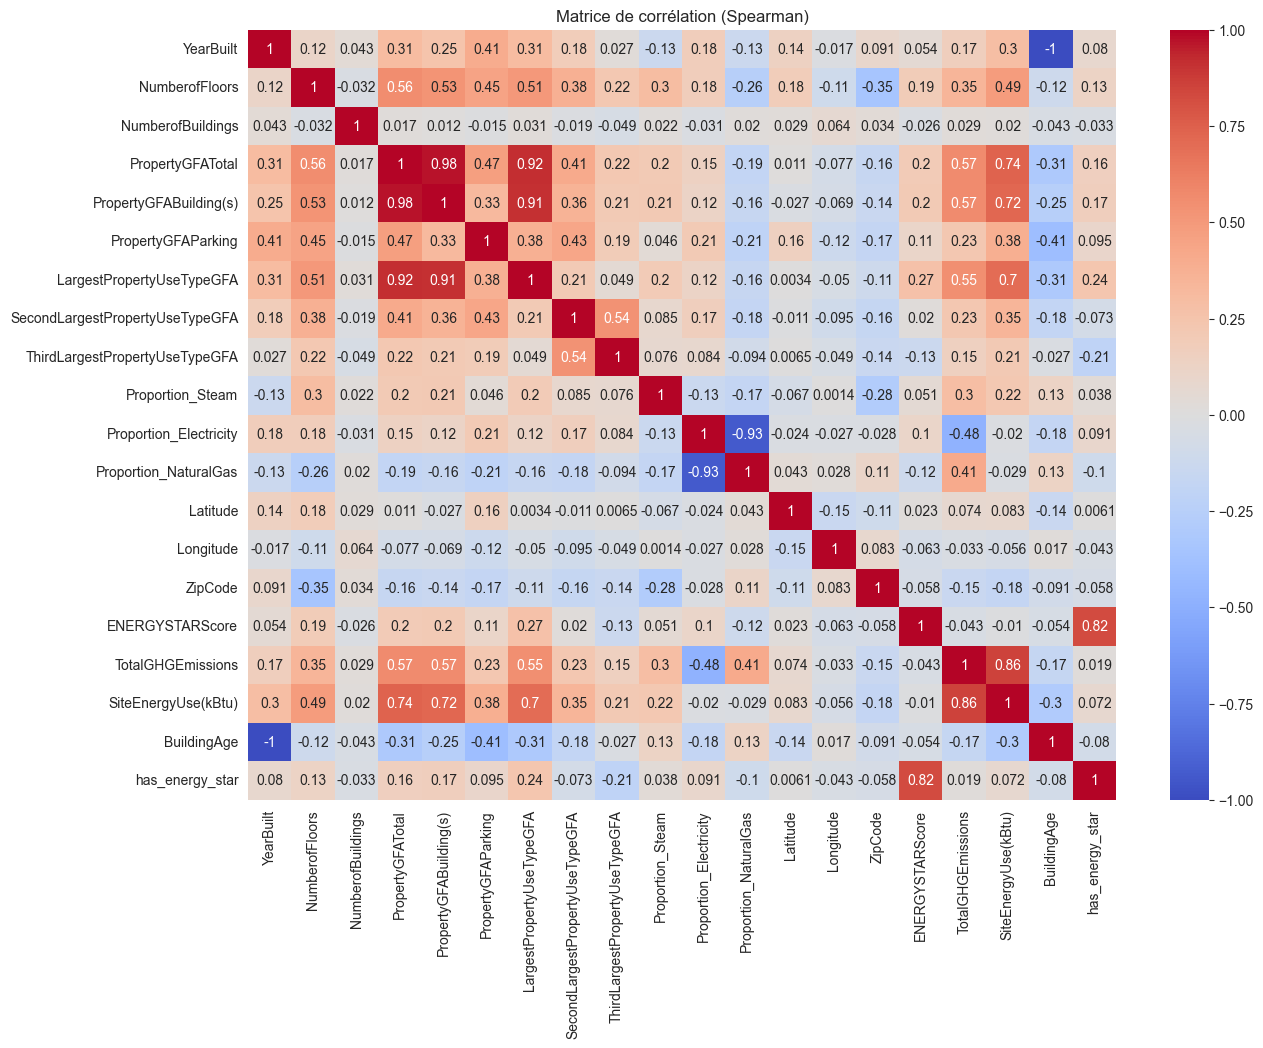

In [19]:
spearman_corr = dataset_model[numeric_cols].corr(method='spearman')
plt.figure(figsize=(14, 10))
sns.heatmap(spearman_corr, cmap='coolwarm', center=0, annot=True)
plt.title("Matrice de corrélation (Spearman)")
plt.show()

- Le coefficient de Spearman révèle des **relations monotones**, même non linéaires.
- On retrouve globalement les mêmes variables influentes qu’en Pearson, ce qui confirme leur importance.

## 1.13 - Analyse en Composantes Principales (ACP)

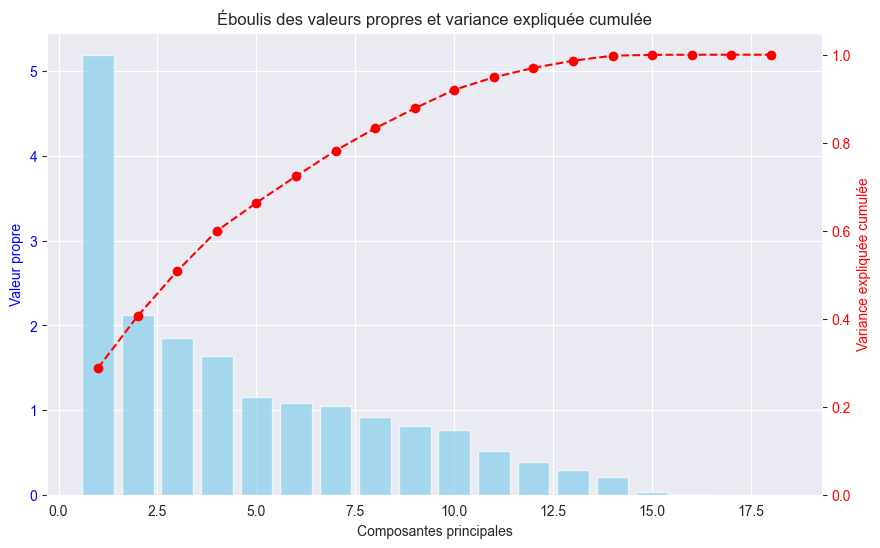

In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

colonnes_acp = dataset_model[numeric_cols].drop(columns=["TotalGHGEmissions", "SiteEnergyUse(kBtu)"]).columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dataset_model[colonnes_acp])
acp = PCA(n_components=X_scaled.shape[1])
X_acp = acp.fit_transform(X_scaled)

eigenvalues = acp.explained_variance_
explained_variance_ratio = acp.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Éboulis
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(range(1, len(eigenvalues) + 1), eigenvalues, color='skyblue', alpha=0.7)
ax1.set_xlabel("Composantes principales")
ax1.set_ylabel("Valeur propre", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='red')
ax2.set_ylabel("Variance expliquée cumulée", color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 1.05)
plt.title("Éboulis des valeurs propres et variance expliquée cumulée")
plt.grid()
plt.show()

- L’éboulis montre que **5 composantes principales suffisent à expliquer environ 75 %** de la variance totale.
- Les deux premières composantes à elles seules capturent presque **la moitié de l'information**, ce qui est utile pour la visualisation ou une réduction de dimension.

## 1.14 - Cercles de corrélation

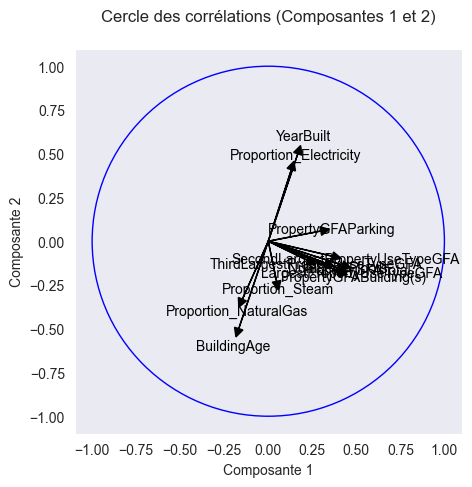

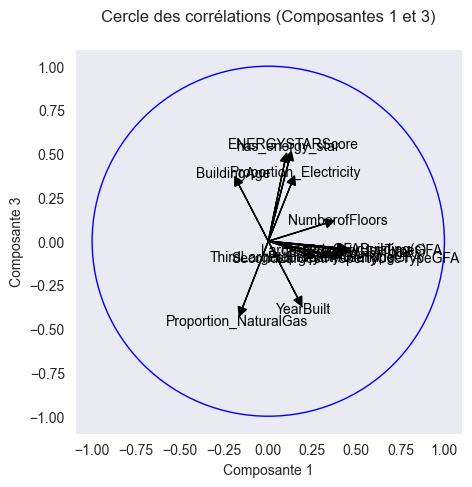

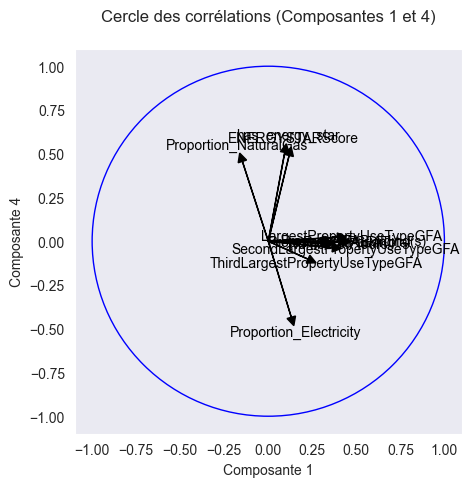

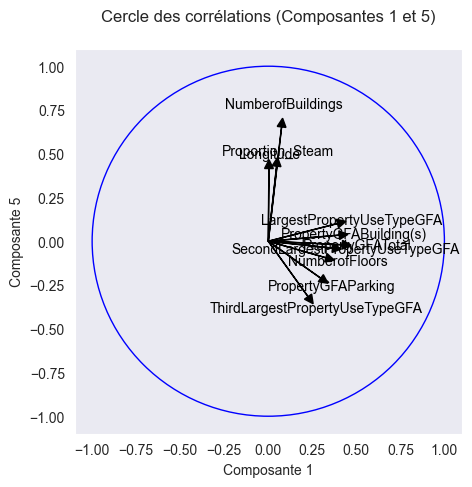

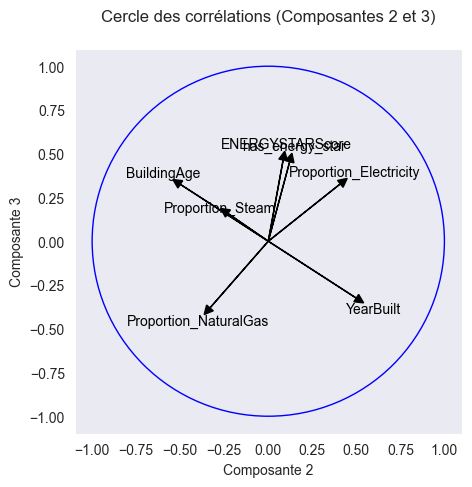

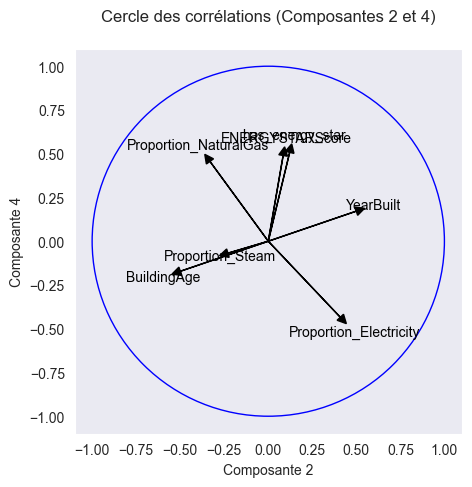

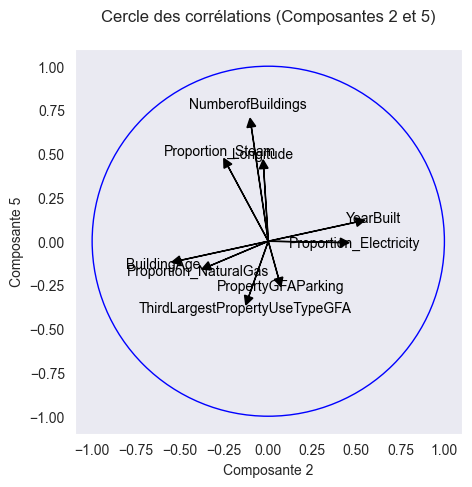

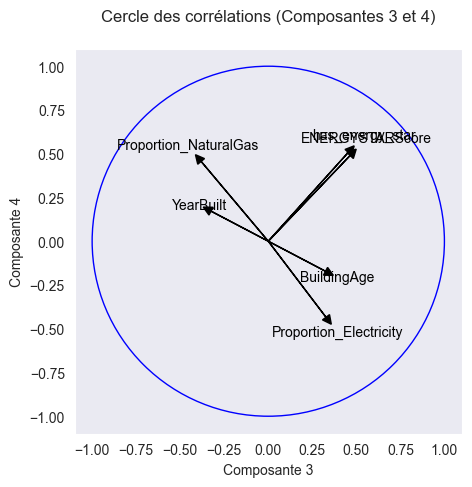

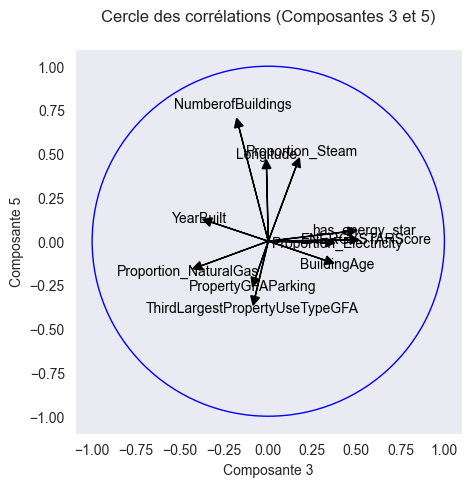

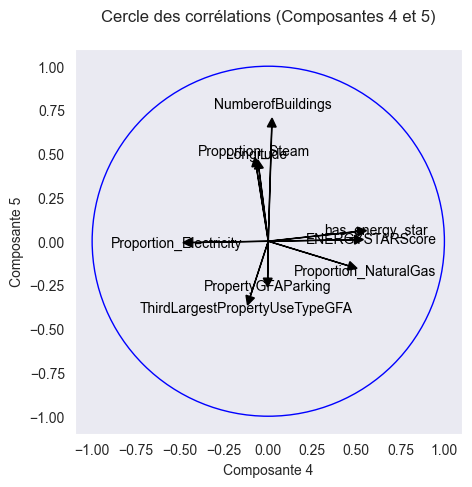

In [21]:
for axis1 in range(5):
    for axis2 in range(axis1 + 1, 5):
        f.cercle_correlations(acp, colonnes_acp, axis1, axis2)

- Les variables liées à la **taille et à l’usage** du bâtiment contribuent fortement à la PC1.
- Certaines variables sont corrélées entre elles, comme les surfaces des différents usages.
- Le cercle permet de repérer les **axes interprétables** de l’ACP et les **groupes de variables proches**.

- La projection dans l’espace PC1/PC2 montre une **dispersion structurée** des bâtiments selon leurs caractéristiques.
- On observe des **groupes de points** indiquant des profils typiques (ex : très grands bâtiments, bâtiments compacts).

## 1.15 Sélection des variables pour le modèle

In [22]:
# Variables retenues pour le modèle
final_features = [
    "PropertyGFATotal",
    "NumberofBuildings",
    "NumberofFloors",
    "LargestPropertyUseTypeGFA",
    "SecondLargestPropertyUseTypeGFA",
    "ENERGYSTARScore",
    "has_energy_star",
    "BuildingAge",
    'Proportion_Steam',
    'Proportion_Electricity',
    'Proportion_NaturalGas'
]

In [23]:
q95 = dataset['TotalGHGEmissions'].quantile(0.95)
dataset_capped = dataset.copy()
dataset_capped.loc[dataset_capped['TotalGHGEmissions'] > q95, 'TotalGHGEmissions'] = q95

median_emissions = dataset_model["TotalGHGEmissions"].median()
dataset_filtered = (
    dataset_model[dataset_model["TotalGHGEmissions"] <= median_emissions * 20]
    [final_features + ["TotalGHGEmissions", "SiteEnergyUse(kBtu)"]]
    .copy()
)

In [24]:
dataset_filtered.head()

,PropertyGFATotal,NumberofBuildings,NumberofFloors,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ENERGYSTARScore,has_energy_star,BuildingAge,Proportion_Steam,Proportion_Electricity,Proportion_NaturalGas,TotalGHGEmissions,SiteEnergyUse(kBtu)
0,88434,1.0,12,88434.0,0.0,60.0,1,98,0.277302,0.546060,0.176638,249.98,7226362.5
1,103566,1.0,11,83880.0,15064.0,61.0,1,29,0.000000,0.386609,0.613391,295.86,8387933.0
3,61320,1.0,10,61320.0,0.0,56.0,1,99,0.325913,0.407519,0.266567,286.43,6794584.0
4,175580,1.0,18,123445.0,68009.0,75.0,1,45,0.000000,0.378802,0.621198,505.01,14172606.0
6,83008,1.0,11,81352.0,0.0,27.0,1,99,0.000000,0.488160,0.511840,176.14,5758795.0


<Axes: >

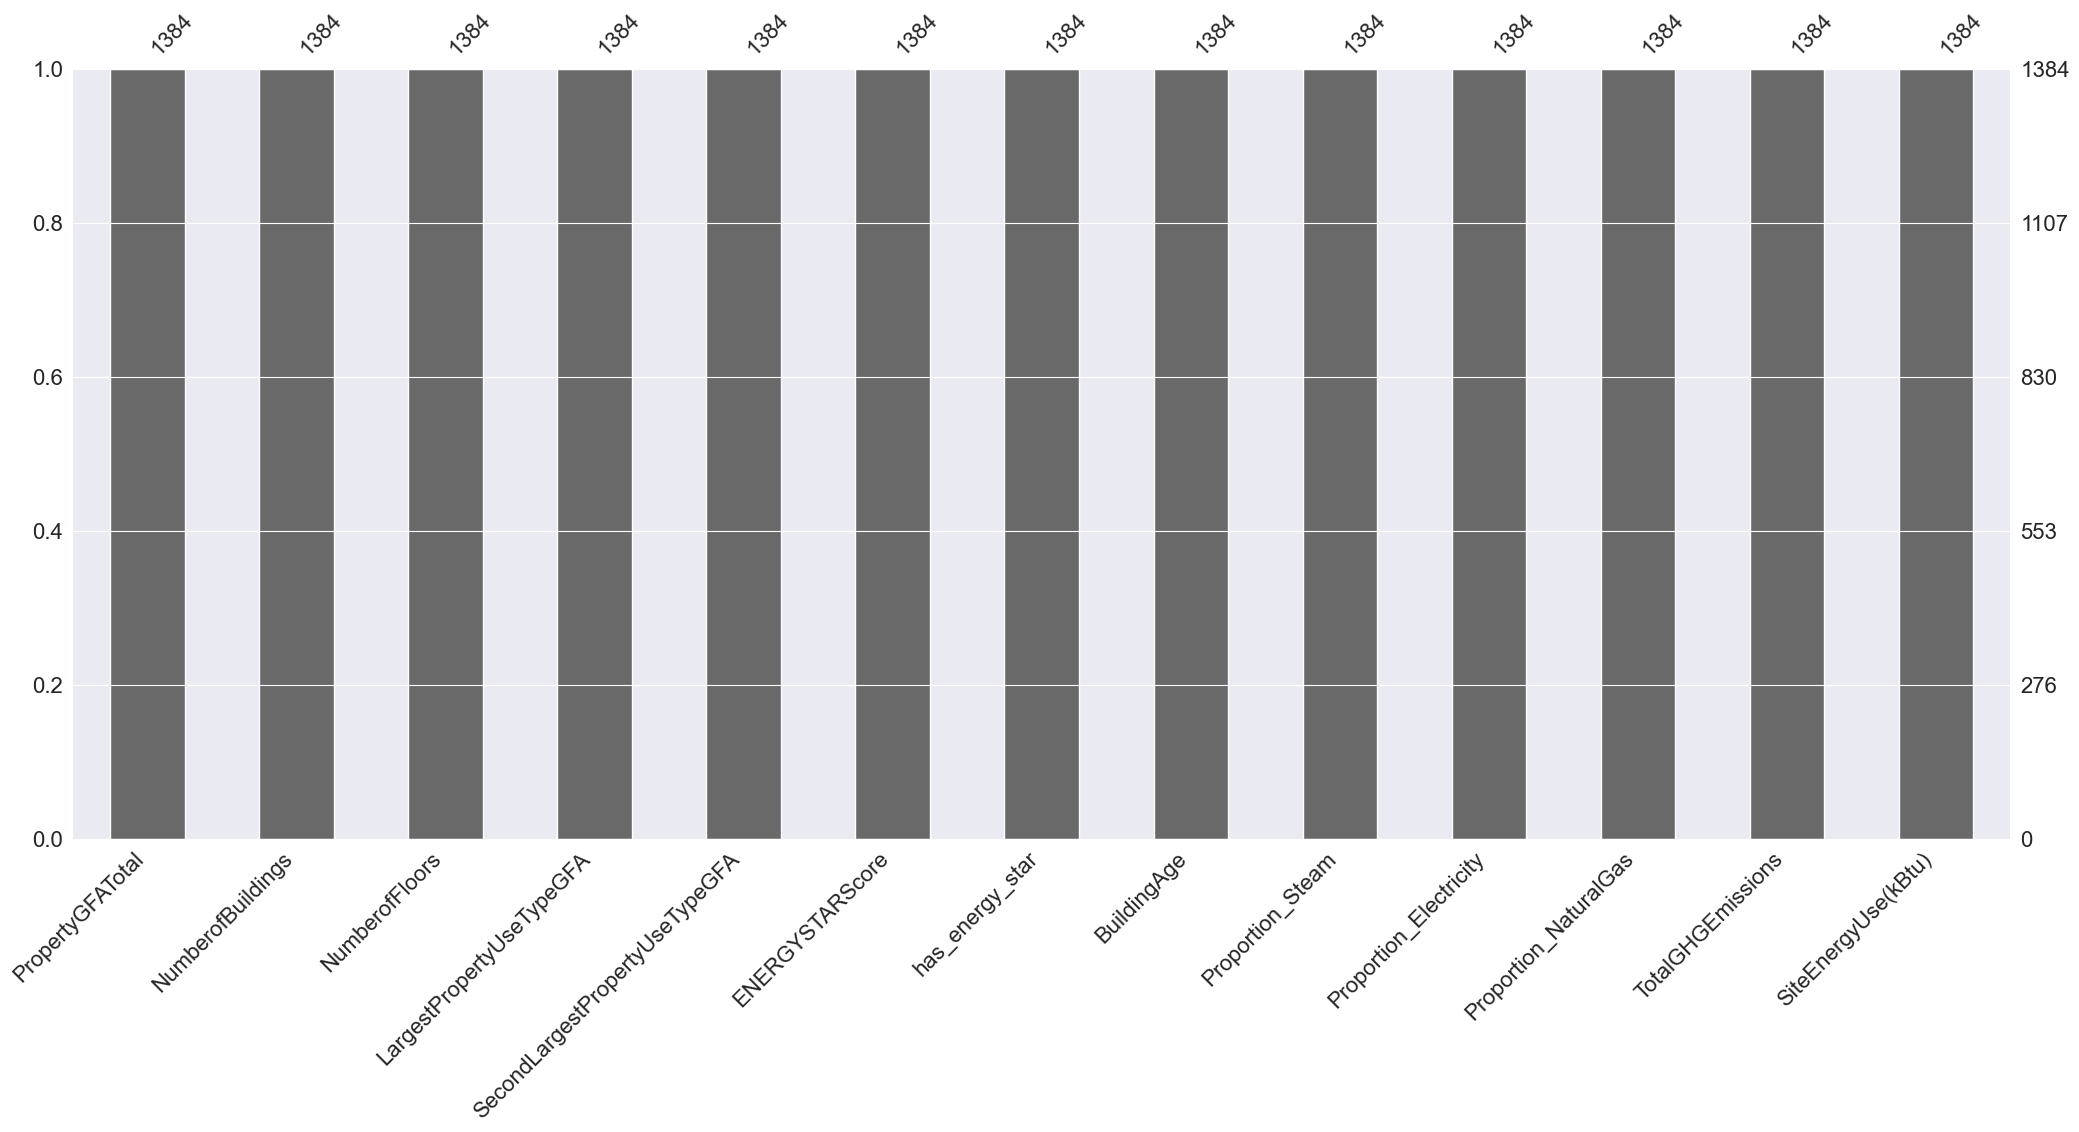

In [25]:
msno.bar(dataset_filtered)

In [26]:
dataset_filtered.to_csv('dataset_filtered_co2.csv', index=False)

In [27]:
print(dataset_filtered.columns)

Index(['PropertyGFATotal', 'NumberofBuildings', 'NumberofFloors',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'has_energy_star', 'BuildingAge', 'Proportion_Steam',
       'Proportion_Electricity', 'Proportion_NaturalGas', 'TotalGHGEmissions',
       'SiteEnergyUse(kBtu)'],
      dtype='object')
